# CurveCall Classification

In [1]:
import pandas as pd, numpy as np
# To suppress scikit-learn warnings
import warnings
warnings.filterwarnings('ignore') 
# For plotting
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

## Load the data

In [2]:
# Data for training
train_dat = pd.read_csv('../datasets/Trainingset.csv')
train_dat.columns.values[0] = 'id'

# Data for final validation 
final_val_dat = pd.read_csv('../datasets/Validationset.csv')
final_val_dat.columns.values[0] = 'id'

print(train_dat.shape)
train_dat.head()

(1000, 9)


,id,cq,baseline,plateau,slope,inflection,asymmetry,drift,CurveCall
0,53369,39.381426,18.862292,35.527769,-0.447984,35.357707,5.5,0.036513,True
1,182009,26.649803,23.902034,25.035602,-0.138960,13.677998,5.5,0.026517,False
2,95707,38.088840,19.150485,37.676668,-0.429194,33.888961,5.5,0.043123,True
3,449346,38.118073,17.925782,37.875329,-0.412705,33.750390,5.5,-0.017076,True
4,292414,38.412099,16.631370,30.774217,-0.442670,34.340077,5.5,-0.002722,True


##  Preprocess the data

In [3]:
train_dat = train_dat.drop(['id'], axis=1) #drop id column, not used in training 
train_dat.info() #Missing 181 values for cq in Training data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   cq          819 non-null    float64
 1   baseline    1000 non-null   float64
 2   plateau     1000 non-null   float64
 3   slope       1000 non-null   float64
 4   inflection  1000 non-null   float64
 5   asymmetry   1000 non-null   float64
 6   drift       1000 non-null   float64
 7   CurveCall   1000 non-null   bool   
dtypes: bool(1), float64(7)
memory usage: 55.8 KB


In [4]:
train_dat_1 = train_dat.dropna() # training dataset without rows with null cq values
train_dat_2 = train_dat.drop('cq', axis=1) # training dataset without cq values
train_dat_0 = train_dat # for training models using imputation 

print(train_dat_0.shape)
print(train_dat_1.shape)
print(train_dat_2.shape)

(1000, 8)
(819, 8)
(1000, 7)


In [5]:
from sklearn.model_selection import train_test_split

# Create arrays for the features and the response variable
y0 = train_dat_0['CurveCall'].values
X0 = train_dat_0.drop('CurveCall', axis=1).values

y1 = train_dat_1['CurveCall'].values
X1 = train_dat_1.drop('CurveCall', axis=1).values

y2 = train_dat_2['CurveCall'].values
X2 = train_dat_2.drop('CurveCall', axis=1).values

# Split into training and validation data, stratified sampling   
X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0, test_size=0.3, random_state=15, stratify = y0)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=15, stratify = y1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=15, stratify = y2)

In [6]:
# Final validation set
X_final_1 = final_val_dat[final_val_dat['cq'].notnull()] # set with rows with cq
X_final_2 = final_val_dat[final_val_dat['cq'].isnull()].drop('cq', axis=1) # set with rows without cq
print(X_final_1.shape)
print(X_final_2.shape)

(81, 8)
(19, 7)


## Classification Models 

In [7]:
# Importing packages and some commonly used functions 
from sklearn import metrics
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
%run ./my_utils.ipynb


In [8]:
# Initiate sum table for storing metrics of models for later comparison 
sum_table = pd.DataFrame(columns=['model', 'acc', 'f1', 'auc','av_pr','best_acc'])

### Quick Look at Candidate Models 

LR: 0.959891 (0.017406)
KNN: 0.984301 (0.012182)
NB: 0.989564 (0.013915)
SVC: 0.984301 (0.012182)
CART: 0.977405 (0.020530)
BAG: 0.975560 (0.020943)
ADA: 0.975620 (0.019386)
GB: 0.986086 (0.015129)
RF: 0.987840 (0.011083)
XGB: 0.987840 (0.011083)


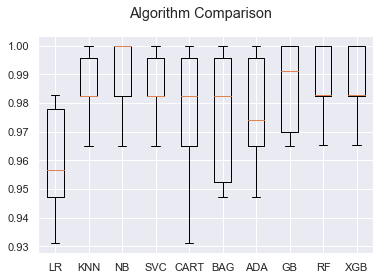

In [9]:
# Compare Algorithms
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# load dataset
X = X_train1
Y = y_train1
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('BAG', BaggingClassifier(DecisionTreeClassifier())))
models.append(('ADA', AdaBoostClassifier(DecisionTreeClassifier())))
models.append(('GB', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=15)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

With default parameters: K-nearest neighbors, Naive bayes, Support vector classifier, Adaboost, Gradient boost, Random forest, and XGBoost show promising results. 
I would still like to look at all the models, such as Decision tree classifier (CART) which are interpretable. 

## Logistic Regression
Does not require feature scaling or much tuning of parameters. Performs poorly with irrelevant or highly correlated features, which may be the case with our data. 

Train_dat_1:
Accuracy:  0.983739837398374
AUC:  0.982487922705314
Average Precision:  0.9755453719133463
f1:  0.9856115107913668
              precision    recall  f1-score   support

       False     0.9906    0.9722    0.9813       108
        True     0.9786    0.9928    0.9856       138

    accuracy                         0.9837       246
   macro avg     0.9846    0.9825    0.9835       246
weighted avg     0.9838    0.9837    0.9837       246

Tuned Parameters:  {'logreg__C': 100, 'logreg__penalty': 'l2'}
Best model accuracy:  0.9825166364186326

Train_dat_2:
Accuracy:  0.9633333333333334
AUC:  0.9644390767579173
Average Precision:  0.93353298875038
f1:  0.9608540925266904
              precision    recall  f1-score   support

       False     0.9809    0.9506    0.9655       162
        True     0.9441    0.9783    0.9609       138

    accuracy                         0.9633       300
   macro avg     0.9625    0.9644    0.9632       300
weighted avg     0.9639    0.9633    0

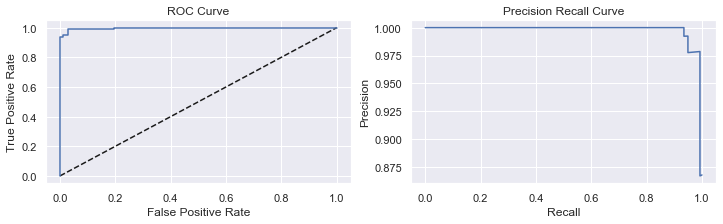

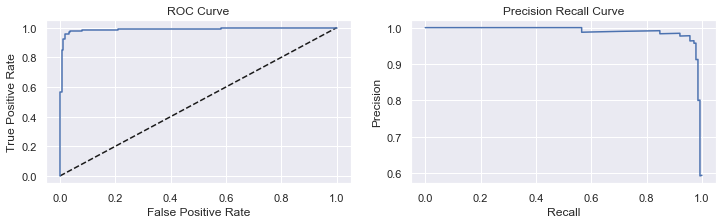

In [10]:
from sklearn.linear_model import LogisticRegression

def logistic_reg_model(X_train, y_train, X_test, y_test, sum_table): 
    steps = [('scaler', PowerTransformer(method='yeo-johnson') ), ('logreg', LogisticRegression())]
    pipeline = Pipeline(steps)
    param_grid = {'logreg__penalty': ['l1', 'l2'], 'logreg__C': [1,2,10,100]} #np.logspace(-2, 2, 50)}
    logreg_cv = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=10)
    logreg_cv.fit(X_train, y_train)
    y_pred = logreg_cv.predict(X_test)
    sum_table = print_model_metrics(logreg_cv, X_test, y_test, y_pred, 'logistic_reg', sum_table, tuning=True, roc_pr=True)
    best_model = logreg_cv.best_estimator_.named_steps['logreg']
    return best_model, sum_table

print("Train_dat_1:")    
logreg_model_1, sum_table = logistic_reg_model(X_train1, y_train1, X_test1, y_test1, sum_table)
print("\nTrain_dat_2:")
logreg_model_2, sum_table = logistic_reg_model(X_train2, y_train2, X_test2, y_test2, sum_table)

## K-Nearest Neighbor
Does not make assumptions for data. Scaling of data is important, does not work well on imbalanced data, sensitive to outliers, and cannot handle missing data. 

Train_dat_0:
Accuracy:  0.9866666666666667
AUC:  0.9865807836822328
Average Precision:  0.9778911993278723
f1:  0.9855072463768116
              precision    recall  f1-score   support

       False     0.9877    0.9877    0.9877       162
        True     0.9855    0.9855    0.9855       138

    accuracy                         0.9867       300
   macro avg     0.9866    0.9866    0.9866       300
weighted avg     0.9867    0.9867    0.9867       300

Tuned Parameters:  {'knn__n_neighbors': 5}
Best model accuracy:  0.9928571428571429


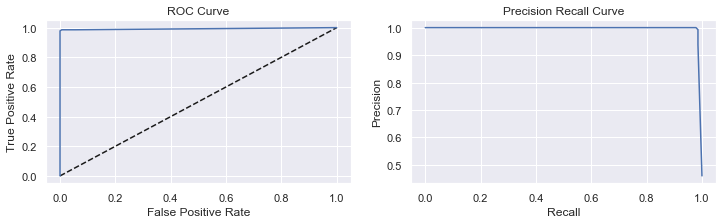

In [11]:
# KNN model 0 imputation 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer

def knn_model_0(X_train, y_train, X_test, y_test, sum_table): 
    steps = [('impute', KNNImputer()),('knn', KNeighborsClassifier())]
    pipeline = Pipeline(steps)
    param_grid = {'knn__n_neighbors': [5]}
    knn_cv = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=10)
    knn_cv.fit(X_train, y_train)
    y_pred = knn_cv.predict(X_test)
    sum_table = print_model_metrics(knn_cv, X_test, y_test, y_pred, 'knn_0', sum_table, tuning=True, roc_pr=True)
    best_model = knn_cv.best_estimator_.named_steps['knn']
    return best_model, sum_table

print("Train_dat_0:")   
knn_model_0, sum_table = knn_model_0(X_train0, y_train0, X_test0, y_test0, sum_table)

Train_dat_1:
Accuracy:  0.9878048780487805
AUC:  0.9881239935587761
Average Precision:  0.9864438441274289
f1:  0.9890909090909091
              precision    recall  f1-score   support

       False     0.9817    0.9907    0.9862       108
        True     0.9927    0.9855    0.9891       138

    accuracy                         0.9878       246
   macro avg     0.9872    0.9881    0.9876       246
weighted avg     0.9878    0.9878    0.9878       246

Tuned Parameters:  {'knn__n_neighbors': 5}
Best model accuracy:  0.984271022383545

Train_dat_2:
Accuracy:  0.9866666666666667
AUC:  0.9865807836822328
Average Precision:  0.9778911993278723
f1:  0.9855072463768116
              precision    recall  f1-score   support

       False     0.9877    0.9877    0.9877       162
        True     0.9855    0.9855    0.9855       138

    accuracy                         0.9867       300
   macro avg     0.9866    0.9866    0.9866       300
weighted avg     0.9867    0.9867    0.9867       300



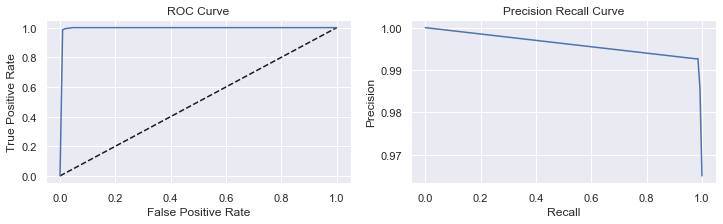

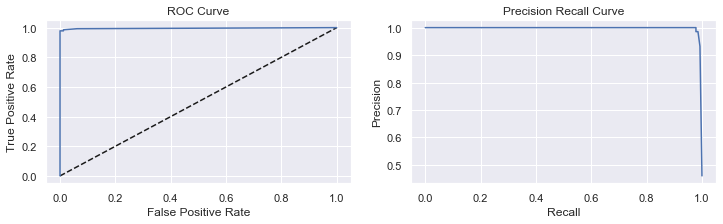

In [12]:
# KNN model
from sklearn.neighbors import KNeighborsClassifier

def knn_model(X_train, y_train, X_test, y_test, sum_table): 
    steps = [('knn', KNeighborsClassifier())]
    pipeline = Pipeline(steps)
    param_grid = {'knn__n_neighbors': [5]}
    knn_cv = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=10)
    knn_cv.fit(X_train, y_train)
    y_pred = knn_cv.predict(X_test)
    sum_table = print_model_metrics(knn_cv, X_test, y_test, y_pred, 'knn', sum_table, tuning=True, roc_pr=True)
    best_model = knn_cv.best_estimator_.named_steps['knn']
    return best_model, sum_table

print("Train_dat_1:")   
knn_model_1, sum_table = knn_model(X_train1, y_train1, X_test1, y_test1, sum_table)
print("\nTrain_dat_2:")
knn_model_2, sum_table = knn_model(X_train2, y_train2, X_test2, y_test2, sum_table)

# Tuning parameters did not improve performance over default model 

## Naive Bayes
Less sensitive to irrelevant features. Assume all variables in independent. This may not work well for the PCR curve variables which are correlated. 

Train_dat_1:
Accuracy:  0.9878048780487805
AUC:  0.9891304347826086
Average Precision:  0.9904559915164369
f1:  0.989010989010989
              precision    recall  f1-score   support

       False     0.9730    1.0000    0.9863       108
        True     1.0000    0.9783    0.9890       138

    accuracy                         0.9878       246
   macro avg     0.9865    0.9891    0.9877       246
weighted avg     0.9881    0.9878    0.9878       246

Tuned Parameters:  {}
Best model accuracy:  0.9912885662431943

Train_dat_2:
Accuracy:  0.9866666666666667
AUC:  0.9865807836822328
Average Precision:  0.9778911993278723
f1:  0.9855072463768116
              precision    recall  f1-score   support

       False     0.9877    0.9877    0.9877       162
        True     0.9855    0.9855    0.9855       138

    accuracy                         0.9867       300
   macro avg     0.9866    0.9866    0.9866       300
weighted avg     0.9867    0.9867    0.9867       300

Tuned Parameters:  {}

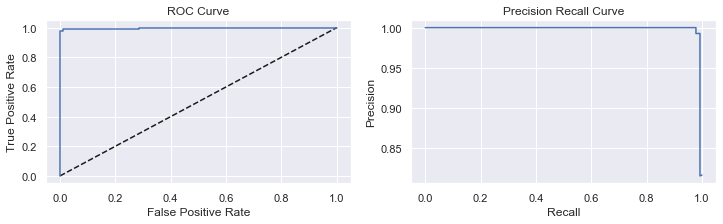

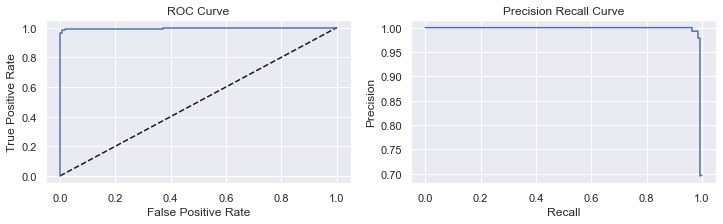

In [13]:
# Default Naive bayes model. No known prior available for tuning.   
from sklearn.naive_bayes import GaussianNB

def nb_model(X_train, y_train, X_test, y_test, sum_table):
    steps = [('nb', GaussianNB())]
    pipeline = Pipeline(steps)
    param_grid = {}
    nb_cv = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=10)
    nb_cv.fit(X_train, y_train)
    y_pred = nb_cv.predict(X_test)
    sum_table = print_model_metrics(nb_cv, X_test, y_test, y_pred, 'nb', sum_table, tuning=True, roc_pr=True)
    best_model = nb_cv.best_estimator_.named_steps['nb']
    return best_model, sum_table

print("Train_dat_1:")   
nb_model_1, sum_table = nb_model(X_train1, y_train1, X_test1, y_test1, sum_table)
print("\nTrain_dat_2:")
nb_model_2, sum_table = nb_model(X_train2, y_train2, X_test2, y_test2, sum_table)

## Support Vector Classifier 
Suitable when classes are separable and outliers have less impact. Does not perform well when classes overlap. Does our CurveCall True and False sometimes overlap? 

Train_dat_1:
Accuracy:  0.983739837398374
AUC:  0.982487922705314
Average Precision:  0.9755453719133463
f1:  0.9856115107913668
              precision    recall  f1-score   support

       False     0.9906    0.9722    0.9813       108
        True     0.9786    0.9928    0.9856       138

    accuracy                         0.9837       246
   macro avg     0.9846    0.9825    0.9835       246
weighted avg     0.9838    0.9837    0.9837       246

Tuned Parameters:  {'svc__C': 100, 'svc__kernel': 'rbf'}
Best model accuracy:  0.9878100423472475

Train_dat_2:
Accuracy:  0.9866666666666667
AUC:  0.9871175523349437
Average Precision:  0.9748136645962732
f1:  0.9856115107913668
              precision    recall  f1-score   support

       False     0.9938    0.9815    0.9876       162
        True     0.9786    0.9928    0.9856       138

    accuracy                         0.9867       300
   macro avg     0.9862    0.9871    0.9866       300
weighted avg     0.9868    0.9867    0.986

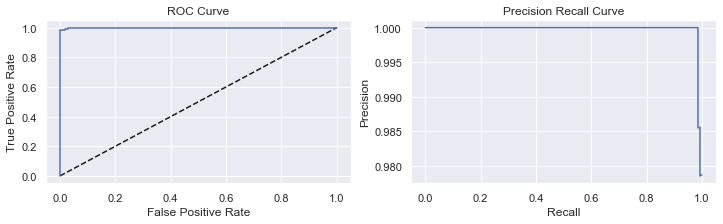

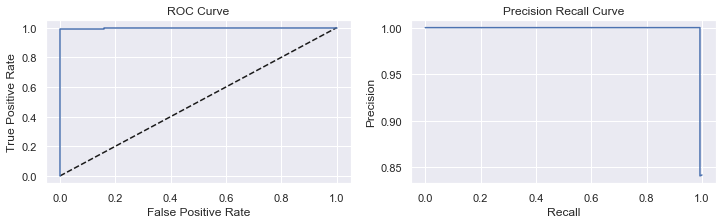

In [14]:
# SVM Classifier with parameter tuning 
from sklearn.svm import SVC

def svc_model(X_train, y_train, X_test, y_test, sum_table):   
    pipeline = Pipeline([('svc', SVC(random_state=15, probability=True))])
    param_grid = {'svc__C':[1, 10, 100], 'svc__kernel': ['rbf','sigmoid']}
    svc_cv = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=10)
    svc_cv.fit(X_train, y_train)
    y_pred = svc_cv.predict(X_test)
    sum_table = print_model_metrics(svc_cv, X_test, y_test, y_pred, 'svc', sum_table, tuning=True, roc_pr=True)
    best_model = svc_cv.best_estimator_.named_steps['svc']
    return best_model, sum_table

print("Train_dat_1:")   
svc_model_1, sum_table = svc_model(X_train1, y_train1, X_test1, y_test1, sum_table) 
print("\nTrain_dat_2:")
svc_model_2, sum_table = svc_model(X_train2, y_train2, X_test2, y_test2, sum_table) 

## Decision Tree Classifier
Interpretable and visualizable, normalization of data not necessary, handles missing values well, and automatically selects relevant features. Prone to overfitting and sensitive to data.  

In [15]:
from sklearn.tree import DecisionTreeClassifier

def tree_model1(X_train, y_train, X_test, y_test, sum_table, criterion):        
    tree = DecisionTreeClassifier(random_state=15, criterion = criterion)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    sum_table = print_model_metrics(tree, X_test, y_test, y_pred, 'tree', sum_table, tuning=False, roc_pr=False)
    return tree, sum_table

print("Train_dat_1:")    
tree_model_1, sum_table = tree_model1(X_train1, y_train1, X_test1, y_test1, sum_table, criterion = 'gini');
print("\nTrain_dat_2:")
tree_model_2, sum_table = tree_model1(X_train2, y_train2, X_test2, y_test2, sum_table, criterion = 'entropy');

# Chosen parameters are gini criterion for train_dat_1, and entropy for train_dat_2

Train_dat_1:
Accuracy:  0.983739837398374
AUC:  0.984500805152979
Average Precision:  0.983262896887281
f1:  0.9854014598540147
              precision    recall  f1-score   support

       False     0.9727    0.9907    0.9817       108
        True     0.9926    0.9783    0.9854       138

    accuracy                         0.9837       246
   macro avg     0.9827    0.9845    0.9835       246
weighted avg     0.9839    0.9837    0.9838       246


Train_dat_2:
Accuracy:  0.9833333333333333
AUC:  0.9834943639291466
Average Precision:  0.9709039724741946
f1:  0.9819494584837546
              precision    recall  f1-score   support

       False     0.9876    0.9815    0.9845       162
        True     0.9784    0.9855    0.9819       138

    accuracy                         0.9833       300
   macro avg     0.9830    0.9835    0.9832       300
weighted avg     0.9834    0.9833    0.9833       300



In [16]:
# Draw Decision Trees
# graphviz package necessary: https://anaconda.org/conda-forge/graphviz
# pydotplus package necessary: https://anaconda.org/conda-forge/pydotplus
import pydotplus
import graphviz 
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

col_names_1 = ['cq','baseline','plateau','slope','inflection','asymmetry','drift']
col_names_2 = ['baseline','plateau','slope','inflection','asymmetry','drift']

def draw_tree(tree_model, col_names, tree_filename): 
    dot_data = tree.export_graphviz(tree_model,
                                feature_names=col_names,
                                class_names= ['False','True'],
                                out_file=None,
                                filled=True,
                                rounded=True)
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.write_png(tree_filename)
    
draw_tree(tree_model_1, col_names_1, '../img/tree_1.png')
draw_tree(tree_model_2, col_names_2, '../img/tree_2.png')


- Decision Tree 1: Training data with rows with missing cq values dropped (full image in img folder).
<img src='../img/tree_1.png' width = 60% >

- Decision Tree 2: Training data all rows and cq values dropped (full image in img folder).
<img src='../img/tree_1.png' width = 60% >


## Bagging Classifier

Train_dat_1:
Accuracy:  0.9634146341463414
AUC:  0.9653784219001611
Average Precision:  0.9634558293932073
f1:  0.9667896678966789
              precision    recall  f1-score   support

       False     0.9381    0.9815    0.9593       108
        True     0.9850    0.9493    0.9668       138

    accuracy                         0.9634       246
   macro avg     0.9615    0.9654    0.9630       246
weighted avg     0.9644    0.9634    0.9635       246

Tuned Parameters:  {'bc__n_estimators': 7}
Best model accuracy:  0.9721113127646703

Train_dat_2:
Accuracy:  0.99
AUC:  0.9896672034353193
Average Precision:  0.9849804294932826
f1:  0.9890909090909091
              precision    recall  f1-score   support

       False     0.9877    0.9938    0.9908       162
        True     0.9927    0.9855    0.9891       138

    accuracy                         0.9900       300
   macro avg     0.9902    0.9897    0.9899       300
weighted avg     0.9900    0.9900    0.9900       300

Tuned Paramet

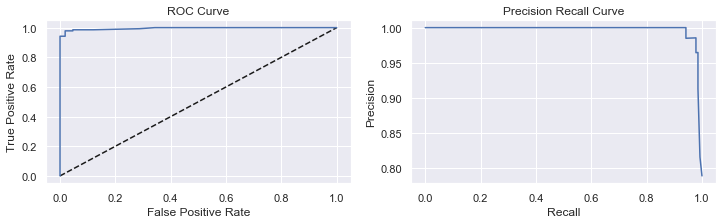

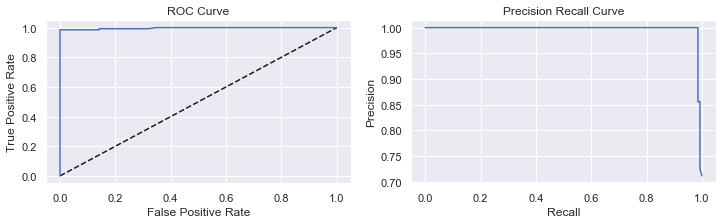

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

def bagging_model(X_train, y_train, X_test, y_test, sum_table):
    dt = DecisionTreeClassifier(max_depth=3, random_state=1)
    bc = BaggingClassifier(base_estimator=dt, random_state=15)
    steps = [('bc', bc)]
    pipeline = Pipeline(steps)
    param_grid = {'bc__n_estimators': [5,6,7,8,9,10]}
    bc_cv = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=10)
    bc_cv.fit(X_train, y_train)
    best_model = bc_cv.best_estimator_
    y_pred = bc_cv.predict(X_test)
    sum_table = print_model_metrics(bc_cv, X_test, y_test, y_pred, 'bagging', sum_table, tuning=True, roc_pr=True)
    best_model = bc_cv.best_estimator_.named_steps['bc']
    return best_model, sum_table

print("Train_dat_1:")    
bag_model_1, sum_table = bagging_model(X_train1, y_train1, X_test1, y_test1, sum_table);
print("\nTrain_dat_2:")
bag_model_2, sum_table = bagging_model(X_train2, y_train2, X_test2, y_test2, sum_table);

## AdaBoost
Improves accuracy by combining weak learners. Not prone to overfitting. Sensitive to outliers and noise. 

Train_dat_1:
Accuracy:  0.9878048780487805
AUC:  0.9881239935587761
Average Precision:  0.9864438441274289
f1:  0.9890909090909091
              precision    recall  f1-score   support

       False     0.9817    0.9907    0.9862       108
        True     0.9927    0.9855    0.9891       138

    accuracy                         0.9878       246
   macro avg     0.9872    0.9881    0.9876       246
weighted avg     0.9878    0.9878    0.9878       246

Tuned Parameters:  {'ada__learning_rate': 1.0, 'ada__n_estimators': 50}
Best model accuracy:  0.9877797943133695

Train_dat_2:
Accuracy:  0.9833333333333333
AUC:  0.9834943639291466
Average Precision:  0.9709039724741946
f1:  0.9819494584837546
              precision    recall  f1-score   support

       False     0.9876    0.9815    0.9845       162
        True     0.9784    0.9855    0.9819       138

    accuracy                         0.9833       300
   macro avg     0.9830    0.9835    0.9832       300
weighted avg     0.9834  

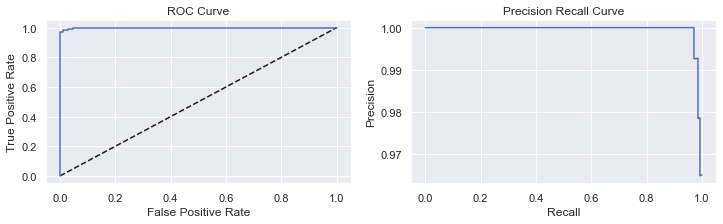

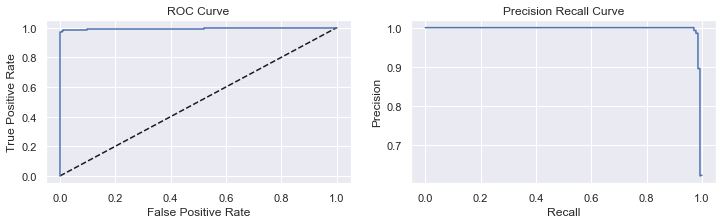

In [18]:
from sklearn.ensemble import AdaBoostClassifier

def adaboost_model(X_train, y_train, X_test, y_test, sum_table):
    dt = DecisionTreeClassifier(max_depth=3, random_state=1)
    ada = AdaBoostClassifier(base_estimator=dt, random_state=15)
    steps = [('ada', ada)]
    pipeline = Pipeline(steps)
    param_grid = {'ada__n_estimators': [50,100,150,200], 
                  'ada__learning_rate': [0.5,1.0]}
    ada_cv = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=10)
    ada_cv.fit(X_train, y_train)
    best_model = ada_cv.best_estimator_
    y_pred = ada_cv.predict(X_test)
    sum_table = print_model_metrics(ada_cv, X_test, y_test, y_pred, 'adaboost', sum_table, tuning=True, roc_pr=True)
    best_model = ada_cv.best_estimator_.named_steps['ada']
    return best_model, sum_table

print("Train_dat_1:")    
ada_model_1, sum_table = adaboost_model(X_train1, y_train1, X_test1, y_test1, sum_table);
print("\nTrain_dat_2:")
ada_model_2, sum_table = adaboost_model(X_train2, y_train2, X_test2, y_test2, sum_table);

## Gradient Boosting Classifier

Train_dat_1:
Accuracy:  0.983739837398374
AUC:  0.984500805152979
Average Precision:  0.983262896887281
f1:  0.9854014598540147
              precision    recall  f1-score   support

       False     0.9727    0.9907    0.9817       108
        True     0.9926    0.9783    0.9854       138

    accuracy                         0.9837       246
   macro avg     0.9827    0.9845    0.9835       246
weighted avg     0.9839    0.9837    0.9838       246

Tuned Parameters:  {'gb__learning_rate': 0.5, 'gb__n_estimators': 50}
Best model accuracy:  0.9877495462794919

Train_dat_2:
Accuracy:  0.9866666666666667
AUC:  0.9865807836822328
Average Precision:  0.9778911993278723
f1:  0.9855072463768116
              precision    recall  f1-score   support

       False     0.9877    0.9877    0.9877       162
        True     0.9855    0.9855    0.9855       138

    accuracy                         0.9867       300
   macro avg     0.9866    0.9866    0.9866       300
weighted avg     0.9867    0.9

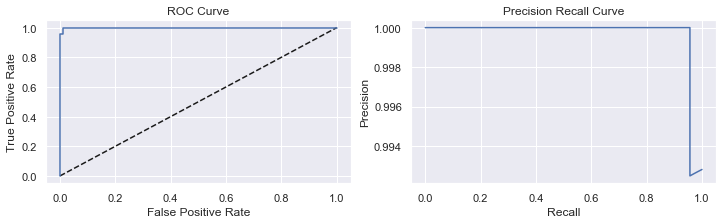

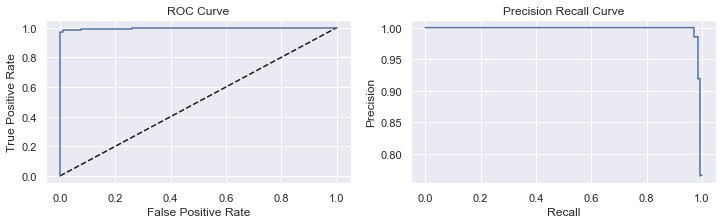

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

def gradboost_model(X_train, y_train, X_test, y_test, sum_table):   
    gb = GradientBoostingClassifier()
    steps = [('gb', gb)]
    pipeline = Pipeline(steps);
    param_grid = {'gb__n_estimators': [50,100,150,200,300], 
                  'gb__learning_rate': [0.1, 0.5,1]}
    gb_cv = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=10);
    gb_cv.fit(X_train, y_train)
    best_model = gb_cv.best_estimator_
    y_pred = gb_cv.predict(X_test)
    sum_table = print_model_metrics(gb_cv, X_test, y_test, y_pred, 'grad', sum_table, tuning=True, roc_pr=True)
    best_model = gb_cv.best_estimator_.named_steps['gb']
    return best_model, sum_table

print("Train_dat_1:")    
gb_model_1, sum_table = gradboost_model(X_train1, y_train1, X_test1, y_test1, sum_table);
print("\nTrain_dat_2:")
gb_model_2, sum_table = gradboost_model(X_train2, y_train2, X_test2, y_test2, sum_table);

## Random Forest 
An ensemble of decision trees to minimize error of invidual trees. Handles missing data, outliers, and imbalance of data well. Robust to overfitting. Unfortunately, random forest is a black box model. 

Train_dat_1:
Accuracy:  0.983739837398374
AUC:  0.984500805152979
Average Precision:  0.983262896887281
f1:  0.9854014598540147
              precision    recall  f1-score   support

       False     0.9727    0.9907    0.9817       108
        True     0.9926    0.9783    0.9854       138

    accuracy                         0.9837       246
   macro avg     0.9827    0.9845    0.9835       246
weighted avg     0.9839    0.9837    0.9838       246

Tuned Parameters:  {'rf__criterion': 'gini', 'rf__n_estimators': 20}
Best model accuracy:  0.9895644283121596

Train_dat_2:
Accuracy:  0.99
AUC:  0.9896672034353193
Average Precision:  0.9849804294932826
f1:  0.9890909090909091
              precision    recall  f1-score   support

       False     0.9877    0.9938    0.9908       162
        True     0.9927    0.9855    0.9891       138

    accuracy                         0.9900       300
   macro avg     0.9902    0.9897    0.9899       300
weighted avg     0.9900    0.9900    0.9900  

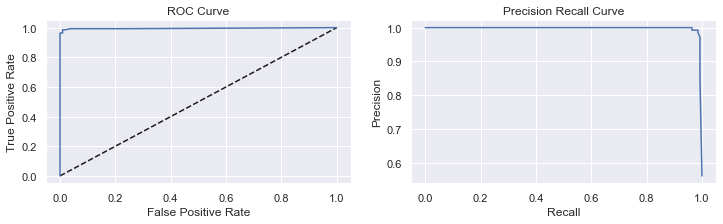

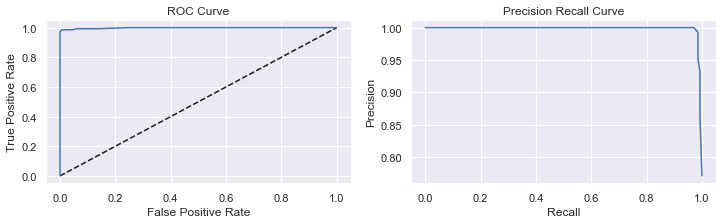

In [20]:
from sklearn.ensemble import RandomForestClassifier

def rforest_model(X_train, y_train, X_test, y_test, sum_table):   
    rf = RandomForestClassifier()
    steps = [('rf', rf)]
    pipeline = Pipeline(steps);
    param_grid = {
        'rf__n_estimators': [10,20,30,40,50],
        'rf__criterion': ['gini','entropy']
        }
    rf_cv = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=10);
    rf_cv.fit(X_train, y_train)
    best_model = rf_cv.best_estimator_
    y_pred = rf_cv.predict(X_test)
    sum_table = print_model_metrics(rf_cv, X_test, y_test, y_pred, 'rforest', sum_table, tuning=True, roc_pr=True)
    best_model = rf_cv.best_estimator_.named_steps['rf']
    return best_model, sum_table

print("Train_dat_1:")    
rf_model_1, sum_table = rforest_model(X_train1, y_train1, X_test1, y_test1, sum_table);
print("\nTrain_dat_2:")
rf_model_2, sum_table = rforest_model(X_train2, y_train2, X_test2, y_test2, sum_table);

## XGBoost Classifier
No need for scaling, can handle missing values and outliers, less prone to overfitting if *well fitted*. Can be difficult to interpret. 

Train_dat_1:
Accuracy:  0.9878048780487805
AUC:  0.9881239935587761
Average Precision:  0.9864438441274289
f1:  0.9890909090909091
              precision    recall  f1-score   support

       False     0.9817    0.9907    0.9862       108
        True     0.9927    0.9855    0.9891       138

    accuracy                         0.9878       246
   macro avg     0.9872    0.9881    0.9876       246
weighted avg     0.9878    0.9878    0.9878       246

Tuned Parameters:  {'xg__learning_rate': 0.1, 'xg__max_depth': 6, 'xg__n_estimators': 100, 'xg__subsample': 0.5}
Best model accuracy:  0.9912885662431942

Train_dat_2:
Accuracy:  0.9833333333333333
AUC:  0.9829575952764358
Average Precision:  0.973979688987623
f1:  0.9818181818181817
              precision    recall  f1-score   support

       False     0.9816    0.9877    0.9846       162
        True     0.9854    0.9783    0.9818       138

    accuracy                         0.9833       300
   macro avg     0.9835    0.9830    0.

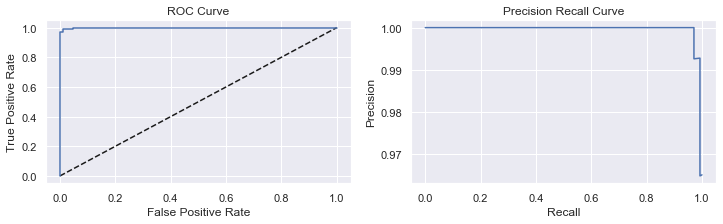

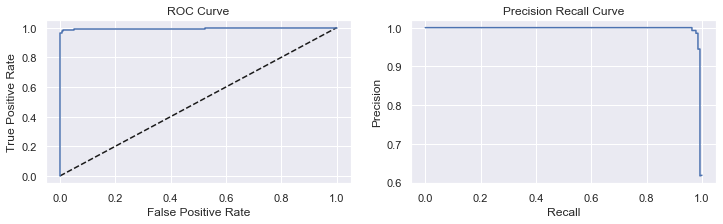

In [21]:
# xgboost package necessary: https://anaconda.org/conda-forge/xgboost
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

def xgboost_model(X_train, y_train, X_test, y_test, sum_table):   
    xg = XGBClassifier()
    steps = [('xg', xg)]
    pipeline = Pipeline(steps);
    param_grid = {
        'xg__max_depth': [6],
        'xg__learning_rate': [0.05, 0.1],
        'xg__subsample': [0.5],
        'xg__n_estimators': [50,100,200]}
    xg_cv = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=10);
    xg_cv.fit(X_train, y_train)
    best_model = xg_cv.best_estimator_
    y_pred = xg_cv.predict(X_test)
    sum_table = print_model_metrics(xg_cv, X_test, y_test, y_pred, 'xgb', sum_table, tuning=True, roc_pr=True)
    best_model = xg_cv.best_estimator_.named_steps['xg']
    return best_model, sum_table

print("Train_dat_1:")    
xgb_model_1, sum_table = xgboost_model(X_train1, y_train1, X_test1, y_test1, sum_table);
print("\nTrain_dat_2:")
xgb_model_2, sum_table = xgboost_model(X_train2, y_train2, X_test2, y_test2, sum_table);


## Voting Classifier
Takes the outputs of the models defined in its list and assigns labels by majority voting. Can perform at least as well as the models in its list.

In [22]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def voting_classifier(X_train, y_train, X_test, y_test, sum_table): 
    knn = KNeighborsClassifier(n_neighbors=5)
   # dt = DecisionTreeClassifier(random_state=15)
    svc = SVC()
    rf = RandomForestClassifier()
    xgb = XGBClassifier()
    classifiers = [
      #  ('K NearestNeighbours', knn), 
                  # ('Classification Tree', dt),
                   ('SVC', svc),
                   ('Random Forest', rf),
                   ('XGB', xgb),
                  ]
    vc = VotingClassifier(estimators=classifiers)
    vc.fit(X_train, y_train)
    y_pred = vc.predict(X_test)
    sum_table = print_model_metrics(vc, X_test, y_test, y_pred, 'voting', sum_table, tuning=False, roc_pr=False)
    return vc, sum_table

print("Train_dat_1:")    
voting_model_1, sum_table = voting_classifier(X_train1, y_train1, X_test1, y_test1, sum_table);
print("\nTrain_dat_2:")
voting_model_2, sum_table = voting_classifier(X_train2, y_train2, X_test2, y_test2, sum_table);


Train_dat_1:
Accuracy:  0.9878048780487805
AUC:  0.9881239935587761
Average Precision:  0.9864438441274289
f1:  0.9890909090909091
              precision    recall  f1-score   support

       False     0.9817    0.9907    0.9862       108
        True     0.9927    0.9855    0.9891       138

    accuracy                         0.9878       246
   macro avg     0.9872    0.9881    0.9876       246
weighted avg     0.9878    0.9878    0.9878       246


Train_dat_2:
Accuracy:  0.9866666666666667
AUC:  0.9865807836822328
Average Precision:  0.9778911993278723
f1:  0.9855072463768116
              precision    recall  f1-score   support

       False     0.9877    0.9877    0.9877       162
        True     0.9855    0.9855    0.9855       138

    accuracy                         0.9867       300
   macro avg     0.9866    0.9866    0.9866       300
weighted avg     0.9867    0.9867    0.9867       300



## Model Comparison

In [23]:
print(sum_table)

           model       acc        f1       auc     av_pr  best_acc
0   logistic_reg  0.983740  0.985612  0.982488  0.975545  0.982517
1   logistic_reg  0.963333  0.960854  0.964439  0.933533  0.978571
2          knn_0  0.986667  0.985507  0.986581  0.977891  0.992857
3            knn  0.987805  0.989091  0.988124  0.986444  0.984271
4            knn  0.986667  0.985507  0.986581  0.977891  0.992857
5             nb  0.987805  0.989011  0.989130  0.990456  0.991289
6             nb  0.986667  0.985507  0.986581  0.977891  0.990000
7            svc  0.983740  0.985612  0.982488  0.975545  0.987810
8            svc  0.986667  0.985612  0.987118  0.974814  0.991429
9           tree  0.983740  0.985401  0.984501  0.983263  0.983740
10          tree  0.983333  0.981949  0.983494  0.970904  0.983333
11       bagging  0.963415  0.966790  0.965378  0.963456  0.972111
12       bagging  0.990000  0.989091  0.989667  0.984980  0.978571
13      adaboost  0.987805  0.989091  0.988124  0.986444  0.98

The sum_table summarizes the performance metric of each model, one for each of training_dat_1 and training_dat_2.  

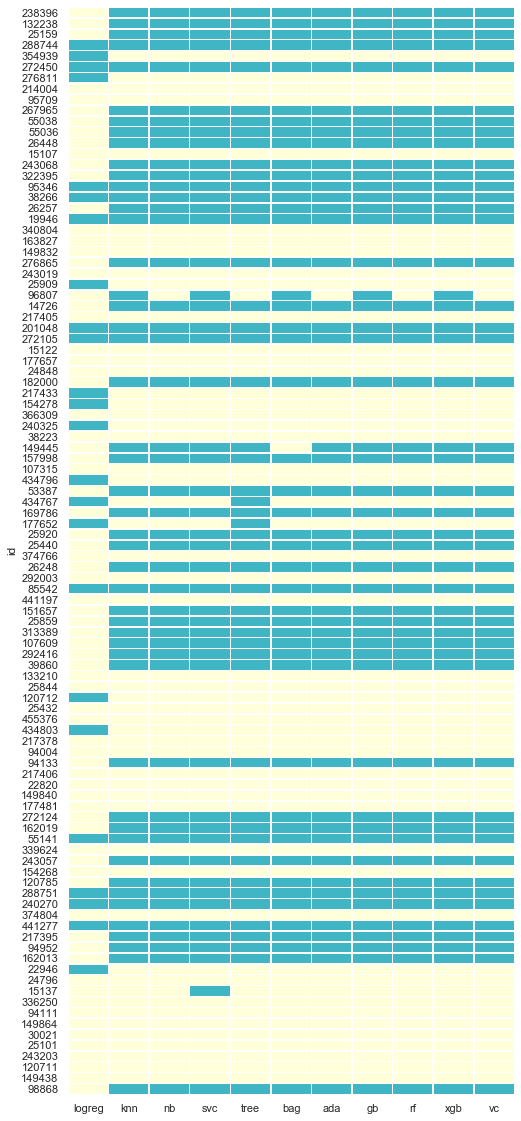

In [24]:
import functools 

# Model predictions on the final Validation Set 
log_pred = make_prediction('logreg',logreg_model_1, logreg_model_2, X_final_1, X_final_2, final_val_dat)
knn_pred = make_prediction('knn', knn_model_1, knn_model_2, X_final_1, X_final_2, final_val_dat)
nb_pred = make_prediction('nb', nb_model_1, nb_model_2, X_final_1, X_final_2, final_val_dat)
svc_pred = make_prediction('svc', svc_model_1, svc_model_2, X_final_1, X_final_2, final_val_dat)
tree_pred = make_prediction('tree', tree_model_1, tree_model_2, X_final_1, X_final_2, final_val_dat)
bag_pred = make_prediction('bag', bag_model_1, bag_model_2, X_final_1, X_final_2, final_val_dat)
ada_pred = make_prediction('ada', ada_model_1, ada_model_2, X_final_1, X_final_2, final_val_dat)
gb_pred = make_prediction('gb',gb_model_1, gb_model_2, X_final_1, X_final_2, final_val_dat)
rf_pred = make_prediction('rf',rf_model_1, rf_model_2, X_final_1, X_final_2, final_val_dat)
xgb_pred = make_prediction2('xgb', xgb_model_1, xgb_model_2, X_final_1, X_final_2, final_val_dat)
vc_pred = make_prediction2('vc',voting_model_1, voting_model_2, X_final_1, X_final_2, final_val_dat)

# Concatenate all predictions into one dataframe 
model_preds = [log_pred, knn_pred, nb_pred, svc_pred, tree_pred,bag_pred, 
                     ada_pred, gb_pred, rf_pred, xgb_pred, vc_pred]

preds_merged = functools.reduce(lambda left,right: pd.merge(left,right,on=['id'], 
                                                        how='outer'), model_preds)
preds_merged.to_csv('../datasets/Python_predictions.csv', index=False)

 # Convert False and True to 0 and 1 for easier visualization
numerical_pred = preds_merged.applymap(lambda x: int(x) if isinstance(x, bool) else x)
numerical_pred_idx = numerical_pred.set_index('id')

# Heatmap of Predictions 
plt.figure(figsize=(8, 20))
sns.heatmap(numerical_pred_idx, cmap="YlGnBu", cbar=False, vmin=0, vmax=2, 
            xticklabels=True, yticklabels=True, lw=0.5);

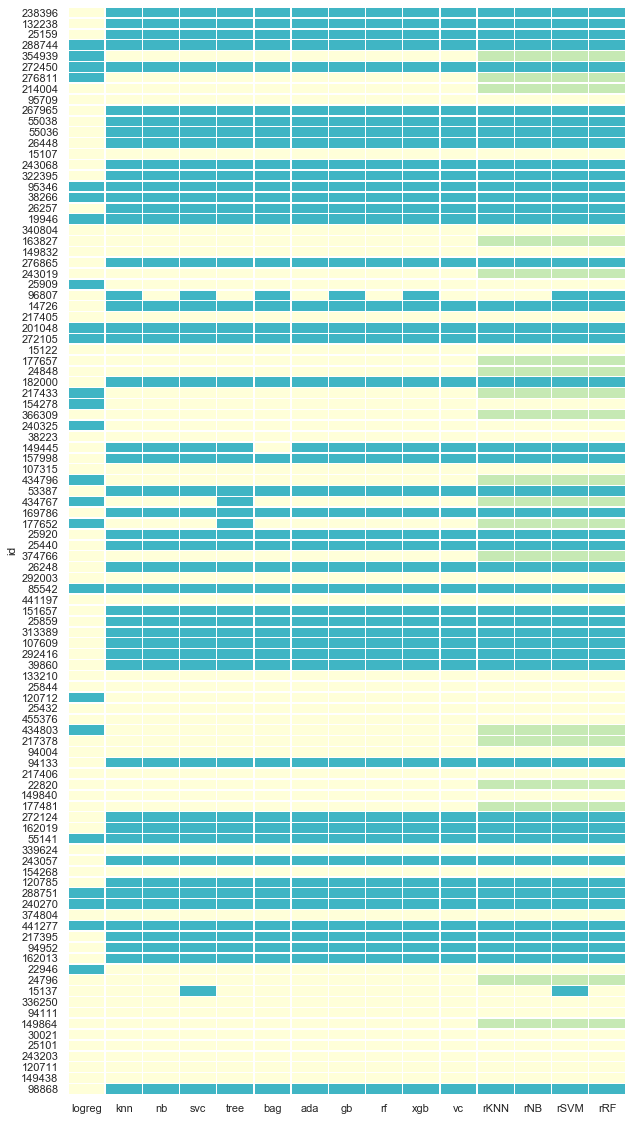

In [26]:
# Combine with earlier R predictions (Data is merged in R)
r_python_merged = pd.read_csv('../datasets/All_model_predictions.csv')
r_python_merged = r_python_merged.set_index('id')
r_python_merged = r_python_merged.reindex(index=numerical_pred['id'])
r_python_merged = r_python_merged.reset_index()
r_python_merged = r_python_merged.set_index('id')

plt.figure(figsize=(10, 20))
pred_plot = sns.heatmap(r_python_merged, cmap="YlGnBu", cbar=False, vmin=0, vmax=2,  
                        xticklabels=True, yticklabels=True, lw=0.5)
fig = pred_plot.get_figure()
fig.savefig("../img/pred_heatmap.png")
plt.show();

<span style="color:teal">**Teal**</span> shows True, 
<span style="color:orange">**yellow**</span> shows False, 
<span style="color:green">**green**</span> shows NA (*R models*) 

Now with the model predictions from R visualized together with the Python model predictions, we see that the r models agree with the corresponding pythons models.

### Best performing models (in no particular order): 
- Random Forest
- Naive Bayes
- XGBoost Classifier 
- Gradient Boosting Classifier 
- AdaBoost
- K-Nearest Neighbor 
- Voting Classifier 
- Bagging Classifier

Less well performing models(with more tuning better models may be possible):
- Decision Tree (would have been nice and interpretable) 
- Support Vector Machine Classifier
- Log Regression